# Exploratory Data Analysis

## Now, we will make 'salary_in_usd' into a categorical data with 4 levels.

In [16]:
### Defining variables
low = df['salary_in_usd'].quantile(0.20) ##Q1
medium_low = df['salary_in_usd'].quantile(0.50)
medium_high = df['salary_in_usd'].quantile(0.80)

### Setting categories
def get_salary_category(salary_in_usd):
    if salary_in_usd <= low:
        return 'Low'
    if low < salary_in_usd <= medium_low:
        return 'Medium Low'
    if medium_low < salary_in_usd <= medium_high:
        return 'Medium High'
    if salary_in_usd > medium_high:
        return 'High'

df['salary_category'] = df['salary_in_usd'].apply(get_salary_category)
df.head()

,work_year,experience_level,job_title,salary_in_usd,work_setting,company_size,job_category,salary_category
7,2024,Entry-level,Insight Analyst,50000,Remote,M,Data Analysis,Low
8,2024,Entry-level,Insight Analyst,40000,Remote,M,Data Analysis,Low
9,2024,Senior,Data Engineer,276000,In-person,M,Data Engineering,High
10,2024,Senior,Data Engineer,148000,In-person,M,Data Engineering,Medium High
11,2024,Senior,Research Scientist,234000,In-person,M,Data Science and Research,High


## Next, we plot the boxplot for experience level against salary.

<Axes: xlabel='experience_level', ylabel='salary_in_usd'>

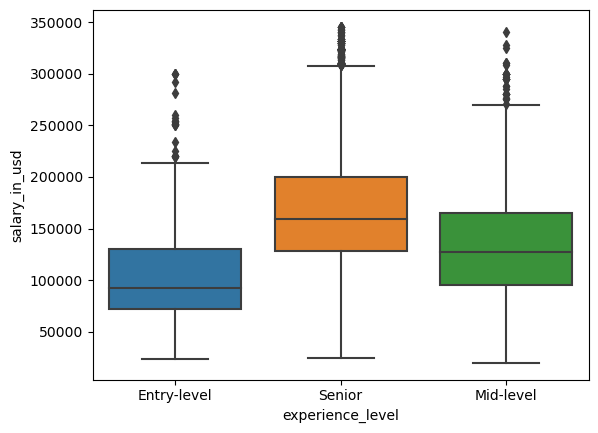

In [87]:
df = df[df['experience_level'].isin(['Entry-level','Mid-level','Senior'])] 
sb.boxplot(x='experience_level',y ='salary_in_usd', data = df)

## Now, we plot the box plot of work_setting against salary.

<Axes: xlabel='work_setting', ylabel='salary_in_usd'>

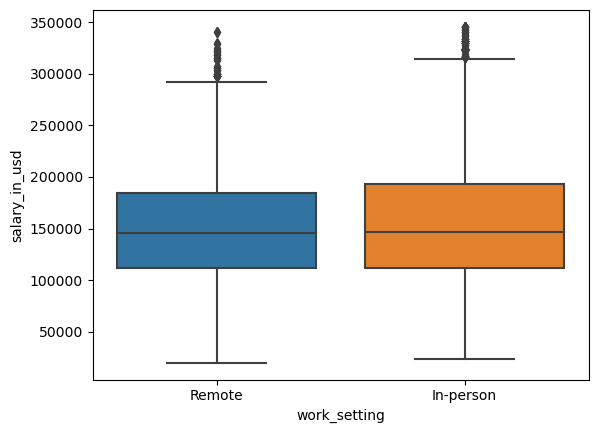

In [18]:
df = df[df['work_setting'].isin(['Remote','In-person'])] 
sb.boxplot(x='work_setting',y ='salary_in_usd', data = df)

## Now, the box plot for company_size against salary. 

<Axes: xlabel='company_size', ylabel='salary_in_usd'>

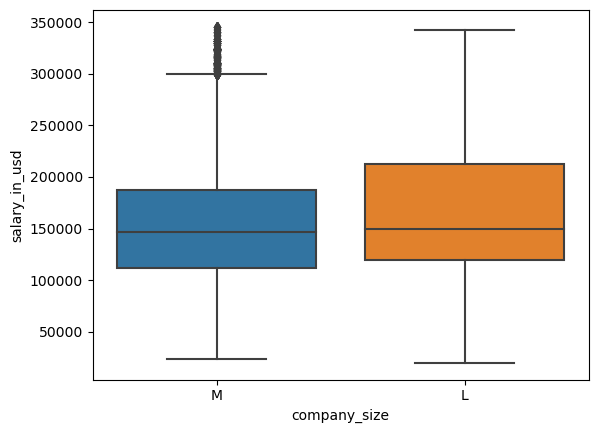

In [19]:
df = df[df['company_size'].isin(['M','L'])] 
sb.boxplot(x='company_size',y ='salary_in_usd', data = df)

## Now, the box plot for job_category against salary.

<Axes: xlabel='job_category', ylabel='salary_in_usd'>

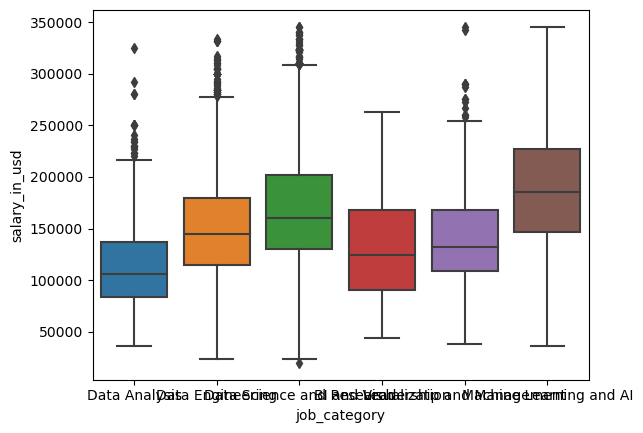

In [20]:
df = df[df['job_category'].isin(['BI and Visualization','Data Analysis', 'Data Engineering','Data Science and Research','Leadership and Management','Machine Learning and AI'])] 
sb.boxplot(x='job_category',y ='salary_in_usd', data = df)

## Now, we will convert the categorical data into numerical data that can be used for analysis. 

In [35]:
df_duplicate = df.copy()

In [36]:
df_duplicate['experience_level'].replace(['Entry-level', 'Mid-level', 'Senior'], [0, 1, 2], inplace = True)
df_duplicate['work_setting'].replace(['Remote', 'In-person'], [0, 1], inplace = True)
df_duplicate['company_size'].replace(['M', 'L'], [0, 1], inplace = True)
df_duplicate['job_category'].replace(['Data Analysis', 'Data Engineering', 'Data Science and Research', 'BI and Visualization', 'Leadership and Management', 'Machine Learning and AI'], [0, 1, 2, 3, 4, 5], inplace = True)
df_duplicate['salary_category'].replace(['Low', 'Medium Low', 'Medium High', 'High'], [0, 1, 2, 3], inplace = True)

In [37]:
new_df = df_duplicate[['experience_level', 'work_setting', 'company_size', 'job_category', 'salary_category']].copy()
new_df

,experience_level,work_setting,company_size,job_category,salary_category
7,0,0,0,0,0
8,0,0,0,0,0
9,2,1,0,1,3
10,2,1,0,1,2
11,2,1,0,2,3
...,...,...,...,...,...
14185,2,0,0,2,2
14186,1,0,0,2,1
14187,1,0,0,2,1
14188,1,0,0,1,1


## Performing Cramer's V Test to find correlation between each categorical variable with salary.

In [38]:
### Cramer's V
from scipy.stats import chi2_contingency
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Loop through each categorical variable
for column in new_df.columns[:-1]:  # Exclude the target variable 'salary_category'
    confusion_matrix = pd.crosstab(new_df['salary_category'], new_df[column])
    if confusion_matrix.values.size == 0:
        print(f"No data for '{column}'. Skipping calculation of Cramér's V.")
    else:
        v = cramers_v(confusion_matrix)
        print(f"Cramér's V between 'salary_category' and '{column}': {v}")

Cramér's V between 'salary_category' and 'experience_level': 0.2536934876376228
Cramér's V between 'salary_category' and 'work_setting': 0.08818612504174299
Cramér's V between 'salary_category' and 'company_size': 0.07920845313704636
Cramér's V between 'salary_category' and 'job_category': 0.2468278606178054


## Finding top variable based on Chi-square scores to determine its importance in determining result of the target variable 'salary_category'.

In [46]:
#We use Chi2score>100 and k=38

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

k = min(38, new_df.shape[1] - 1)
category_rank_feature = SelectKBest(score_func=chi2, k=k)
features = new_df.drop(columns=['salary_category'])
target = new_df['salary_category']
rank_feature = category_rank_feature.fit(features, target)
print(rank_feature.scores_)

[ 313.58331617   28.46326774   70.02626807 1234.91019436]


## Finding the ranking of variables in ascending order. 

In [49]:
cat_score = pd.DataFrame(rank_feature.scores_, columns=['Score'])
cat_col = pd.DataFrame(new_df.columns, columns=['Feature'])
univariate_cat_rank = pd.concat([cat_col, cat_score], axis=1)
univariate_cat_rank.set_index('Feature', inplace=True)
sorted_univariate_cat_rank = univariate_cat_rank.sort_values('Score', ascending=False)
sorted_univariate_cat_rank

,Score
Feature,
job_category,1234.910194
experience_level,313.583316
company_size,70.026268
work_setting,28.463268
salary_category,NaN


## Splitting dataset into train and test data.

In [59]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X = new_df.drop(columns=['salary_category'])  # Features
y = new_df['salary_category']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (9079, 4)
Shape of X_test: (2270, 4)
Shape of y_train: (9079,)
Shape of y_test: (2270,)
